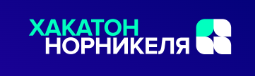

# Трек - Мультимодальные RAG модели 🔍️📊

### Часть 1 - Создание векторной базы

# 1. Установка и импорт нужных инструментов

Установим требуемые нам библиотеки: 
* `byaldi` - высокоуровневый [фреймворк](https://github.com/AnswerDotAI/byaldi) непосредственно для работы с моделями ColPali
* `pdf2image` - для перевода `.pdf`-файлов в изображения
* `poppler-utils` - для работы `pdf2image`
* `Spire.Doc` - для перевода `.docx`-файлов в формат `.pdf`

**Важно!**

Для работы обязательно потребуются данные (сами документы), предоставленные организаторами хакатона (архив `RAG.zip` весом в 450,4 МБ).

In [23]:
!pip install --upgrade byaldi -q
!sudo apt-get install -y poppler-utils -q
!pip install -q pdf2image flash-attn -q
!pip install Spire.Doc -q

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Reading package lists...
Building dependency tree...
Reading state information...
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 72 not upgraded.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# 2. Подготовка данных

Определим папку, где у нас лежат первоначальные данные `input_folder`, а так же папку, куда мы переведём файлы непосредственно для работы с RAG-системой `working_folder`.

In [3]:
from byaldi import RAGMultiModalModel
import torch
from pdf2image import convert_from_path
import os
import shutil
from spire.doc import *
from spire.doc.common import *


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
input_folder = '/kaggle/input/nornikel-2024/'
working_folder = '/kaggle/working/nornikel-2024/'

if not os.path.exists(working_folder):
    os.makedirs(working_folder)

In [4]:
def convert_doc_to_pdf(
    doc_path: str, 
    pdf_path: str
    ) -> None:
    """
    Конвертирует Microsoft Word файл (.doc, .docx) в формат PDF.

    Аргументы:
        doc_path (str): Путь к исходному документу Word (например, 'example.docx').
        pdf_path (str): Путь для сохранения результата в формате PDF (например, 'output.pdf').

    Возвращает:
        None: Функция не возвращает значения, так как результат сохраняется непосредственно в файл.
    """
    document = Document()
    document.LoadFromFile(doc_path)
    document.SaveToFile(pdf_path, FileFormat.PDF)
    document.Close()

In [6]:
all_documents = os.listdir(input_folder)

for file in all_documents:
    file_path = os.path.join(input_folder, file)
    if file_path.endswith('.docx') or file_path.endswith('.doc'):
        file_path = convert_doc_to_pdf(file_path, working_folder + file[:-4] + 'pdf')
        print(f"Копирован и переведён в формат .pdf файл: {file[:-4] + 'pdf'}")
    else:
        shutil.copy(file_path, working_folder)
        print(f"Копирован файл: {file}")

Копирован файл: Alrosa_Обзор_рынка_инвестиционных_бриллиантов_октябрь_2024.pdf
Копирован файл: Росконгресс_Рынок_промышленных_роботов_в_мире_и_России_2024_16_стр.pdf
Копирован файл: nn_climate_change_report_rus.pdf
Копирован файл: Норникель про корп культуру.pdf
Копирован файл: ММК 2024.pdf
Копирован файл: Доклад, уголь часть 1.pdf
Копирован файл: Godovoi_-otchet-PAO-GMK-Norilskii_-nikel-za-2023-god.pdf
Копирован файл: sr_ru_annual_report_pages_nornik_2022.pdf
Копирован файл: Норникель_Внутрення_цена_на_углерод.pdf
Копирован файл: 2_5282802846297776741.pdf
Копирован и переведён в формат .pdf файл: СП_496_1325800_2020_Основания_и_фундаменты_зданий_и_сооружений.pdf
Копирован файл: digital_production_5.pdf
Копирован файл: NN_AR_2021_Book_RUS_26.09.22.pdf
Копирован файл: McKinsey_Next Big Arenas_2024 (213 pgs).pdf
Копирован файл: KPMG_Global Metals and Mining_2024 (48 pgs).pdf
Копирован файл: NN_CSO2021_RUS_03.03.2023.pdf
Копирован файл: 2022_Annual_Report_of_PJSC_MMC_Norilsk_Nickel_rus.

# 3. Индексирование

Определим метод RAGMultiModalModel из библиотеки byaldi, который отвечает за создание мультимодальной RAG-системы с помощью модели ColPali.

In [7]:
RAG = RAGMultiModalModel.from_pretrained("vidore/colpali-v1.2", device=device)

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


adapter_config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

Создадим нашу векторную базу из всех документов, которые у нас есть.

In [8]:
RAG.index(
    input_path=working_folder,
    index_name='nornikel_index',
    store_collection_with_index=False,
    overwrite=True
)

Indexing file: /kaggle/working/nornikel-2024/sr_ru_annual_report_pages_nornik_2022.pdf
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Added page 14 of document 0 to index.
Added page 15 of document 0 to index.
Added page 16 of document 0 to index.
Added page 17 of document 0 to index.
Added page 18 of document 0 to index.
Added page 19 of document 0 to index.
Added page 20 of document 0 to index.
Added page 21 of document 0 to index.
Added page 22 of document 0 to index.
Added page 23 of document 0 to index.
Added page 24 of document 0 to index.
Added page

{0: '/kaggle/working/nornikel-2024/sr_ru_annual_report_pages_nornik_2022.pdf',
 1: '/kaggle/working/nornikel-2024/2_5282802846297776741.pdf',
 2: '/kaggle/working/nornikel-2024/ТеДо_и_СУЭК_Перспективы_развития_экспорта_российского_угля_202.pdf',
 3: '/kaggle/working/nornikel-2024/Доклад, уголь часть 1.pdf',
 4: '/kaggle/working/nornikel-2024/digital_production_5.pdf',
 5: '/kaggle/working/nornikel-2024/KPMG_Global Metals and Mining_2024 (48 pgs).pdf',
 6: '/kaggle/working/nornikel-2024/Godovoi_-otchet-PAO-GMK-Norilskii_-nikel-za-2023-god.pdf',
 7: '/kaggle/working/nornikel-2024/НЛМК 2024.pdf',
 8: '/kaggle/working/nornikel-2024/ММК 2024.pdf',
 9: '/kaggle/working/nornikel-2024/K2Tex_x_TeДо_Российский_рынок_ИТ_2024_30_стр.pdf',
 10: '/kaggle/working/nornikel-2024/nn_climate_change_report_rus.pdf',
 11: '/kaggle/working/nornikel-2024/Kept_Золотодобывающие_компании_2024_25_стр.pdf',
 12: '/kaggle/working/nornikel-2024/Alrosa_Обзор_рынка_инвестиционных_бриллиантов_октябрь_2024.pdf',
 13: '

Сформируем текстовый запрос, чтобы убедиться, что модель работает. Определим k страниц, где есть релевантная информация.

In [20]:
text_query = "Расскажи про рынок блирриантов"
results = RAG.search(text_query, k=5)

[{'doc_id': 12, 'page_num': 33, 'score': 13.0, 'metadata': {}, 'base64': None},
 {'doc_id': 12, 'page_num': 20, 'score': 12.8125, 'metadata': {}, 'base64': None},
 {'doc_id': 12, 'page_num': 35, 'score': 12.6875, 'metadata': {}, 'base64': None},
 {'doc_id': 12, 'page_num': 4, 'score': 12.6875, 'metadata': {}, 'base64': None},
 {'doc_id': 14, 'page_num': 142, 'score': 12.625, 'metadata': {}, 'base64': None}]

In [21]:
for result in results:
    doc_id = result['doc_id']
    page_num = result['page_num']
    score = result['score']

    print(f"Документ ID: {doc_id}, Страница: {page_num}, Релевантность: {score}")

Документ ID: 12, Страница: 33, Релевантность: 13.0
Документ ID: 12, Страница: 20, Релевантность: 12.8125
Документ ID: 12, Страница: 35, Релевантность: 12.6875
Документ ID: 12, Страница: 4, Релевантность: 12.6875
Документ ID: 14, Страница: 142, Релевантность: 12.625


Сохраним нашу векторную базу для дальнейшей эксплуатации.

In [9]:
from zipfile import ZipFile

byaldi_folder = '/kaggle/working/.byaldi'
archive_name = '/kaggle/working/byaldi.zip'

if os.path.exists(byaldi_folder):
    shutil.make_archive(archive_name.replace('.zip', ''), 'zip', byaldi_folder)
    print(f"Архив создан: {archive_name}")
else:
    print(f"Папка {byaldi_folder} не найдена.")


Архив создан: /kaggle/working/byaldi.zip


# Заключение 🏁

Выполнение ноутбука завершено, можно двигаться дальше - ко второй части, где уже показана загрузка готовой базы и выполнение инференсовс помощью Qwen-2-VL. Чтобы продолжить работу, необходимо перейти в `Часть 2`. Ноутбук был разделён на две части специально, чтобы здесь показать создание самой векторной базы, а во второй части - подключение сторонней векторной базы и получение инференсов.

Так же есть all-in-one версия ноутбука, там представлено и создание векторной базы, и дальнейшее получение инференсов с помощью VLM.